### Take time series, associated RV measurement uncertainties, and planet orbital parameters and calculate the generalized (aka expected) Fisher Information Matrix (FIM)

Let's start with the most trivial case of circular orbit and white noise

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)

import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det

import matplotlib.pyplot as plt

1.21.0
1.7.3


In [2]:
print(np.finfo(float).eps) # machine epsilon for float
print(np.finfo(float).precision) 
print(np.finfo(np.double).precision) 
print(np.finfo(np.longdouble).precision) 

2.220446049250313e-16
15
15
18


In [3]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """

    #print("partial mu, partial K: ", partial_mu(t, theta, 'K'))
    #print("partial mu, partial P: ", partial_mu(t, theta, 'P'))
    #print("partial mu, partial T0: ", partial_mu(t, theta, 'T0'))
    factor2 = 1/sigma**2
    factor2[factor2 == np.inf] = 0 
    
    fim = np.zeros((len(theta),len(theta)))
    
    
    
    for i in range(len(theta)):
        for j in range(len(theta)):
            #param_i = theta[i]
            #param_j = theta[j]
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed
            #print(factor1)
            ###factor2 = 1/sigma**2 # inverse of covariance matrix (or just the RV variance if held constant)
            ###factor2[factor2 == np.inf] = 0 # turn infs into zeros (shouldn't it be nans?)
            #print(factor2)
            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter
            #print(factor3)
            #print("shapes: ", factor1.shape, factor2.shape, factor3.shape)
            #print(np.dot(np.dot(factor1, factor2), factor3))
            
            fim[i][j] = np.dot(np.dot(factor1, factor2), factor3)
    
    return fim

Let's try some test observations and planetary orbital parameters.

In [4]:
param_list = ['K','P','T0']

test_t = np.array([2340, 2350, 2380, 2400]) # in Barycentric Julian Dates
#test_t = np.array([2340, 2350, 2360, 2380]) # in Barycentric Julian Dates
#test_t = np.linspace(2340, 2380, 41) # in Barycentric Julian Dates

test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to cm/s
test_P = 10 # days
test_sigma = np.diag(np.ones(len(test_t))*30) # cm/s
print(test_t.shape, test_sigma.shape)


(4,) (4, 4)


In [5]:
test_theta = [test_K, test_P, test_T0]
calculate_fim(test_t, test_sigma, test_theta)

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


array([[ 1.66639976e-33, -2.13741188e-15,  2.56489426e-16],
       [-2.13741188e-15,  2.74155678e+03, -3.28986813e+02],
       [ 2.56489426e-16, -3.28986813e+02,  4.38649084e+02]])

In [6]:
calculate_fim(test_t, test_sigma, test_theta)[0][0]

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


1.666399758513175e-33

In [7]:
det(calculate_fim(test_t, test_sigma, test_theta))

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


-3.3652495654758422e-43

In [8]:
inv(calculate_fim(test_t, test_sigma, test_theta))

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


array([[-3.25191052e+48, -2.53530120e+30,  1.60664679e+13],
       [-2.53530120e+30, -1.97660795e+12,  3.13149263e-04],
       [ 0.00000000e+00,  3.00623292e-04,  2.50519410e-03]])

### What happens to the expected uncertainty on K when you incrementally add observations? 

${{\sigma}_k}^2$ is the top-leftmost cell of the inverse of the FIM. The second diagonal term is ${{\sigma}_P}^2$, and so forth. The off-diagonals contain information about the uncertainties on our uncertainties for each parameter pair, but we will ignore those for now(/forever) because our priors on P and T0 from TESS will be quite strong. 

For reference:

K = 10 cm/s is gold standard. As an upper bound for K, try up to 100 m/s if I only have 10 observations. 

As for N_obs, there are standard stars with 1000s of observations. But 100 would be our upper limit for TESS stars. 

In [37]:
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

test_t = np.linspace(2340, 2440, 101)
buffer = 2 # anything less and either sigma_k blows up, or I get det(fim)=0
sigma_ks = []
sigma_ks_stable = []
sigma_ks_squared = []
for i in range(len(test_t)-(buffer-1)):
    # create time series and appropriately sized covariance matrix
    test_t_temp = test_t[:i+buffer]
    test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s
    
    # calculate FIM
    fim = calculate_fim(test_t_temp, test_sigma, test_theta)
    #print(test_t_temp)
    #print(fim)
    #print(det(fim))
    
    # invert the FIM
    try:
        inv_fim = inv(fim)
    except:
        print("determinant of singular matrix is: ", det(fim), " for ", fim)
    
    # calculate sigma_k
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_k_squared = inv_fim[0][0]
    sigma_ks.append(sigma_k)
    sigma_ks_squared.append(sigma_k_squared)
    #print("sigma: ", sigma_k)
    
    # for det(FIM) <= 1e-15, use sqrt(1/FIM[0][0]) instead
    # why? bc of numerical instability: 
    # https://stackoverflow.com/questions/17136626/what-is-the-correct-stable-efficient-way-to-use-matrix-inversion-in-numpy
    sigma_k_stable = np.sqrt(1/fim[0][0])
    sigma_ks_stable.append(sigma_k_stable)
    
print(sigma_ks)
print(sigma_ks_stable)
#print(sigma_ks_squared)

[nan, 77.43352187572097, 21.097996079939175, 20.896806627714273, 19.743065550785943, 17.97178294634297, 15.84346385787988, 14.013067243073351, 13.786245293433511, 13.634147492972621, 13.026678393732409, 12.09388466597271, 11.253661535695938, 11.090923117356386, 11.04875227883207, 10.732819784413193, 10.182043476508868, 9.673206479472846, 9.5537102589733, 9.537212637459858, 9.339101807400002, 8.965686242512453, 8.61529766981624, 8.52367030477876, 8.515799124256144, 8.377736790895744, 8.103366480659835, 7.843204361014961, 7.77033964037522, 7.7660664179557095, 7.663141762150121, 7.450629235229334, 7.247599572200858, 7.187965110425009, 7.185424772406647, 7.105035232006432, 6.934181932437809, 6.7700254726556395, 6.720094813968561, 6.718479537545975, 6.653516632632693, 6.512288582810893, 6.375995695472347, 6.333416859126473, 6.332335108760056, 6.278459928166207, 6.159184717273299, 6.043669513793351, 6.006811482669014, 6.0060565607673615, 5.960457146182527, 5.857982550656342, 5.75845023669238

/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2
/tmp/ipykernel_3002366/2845214392.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]


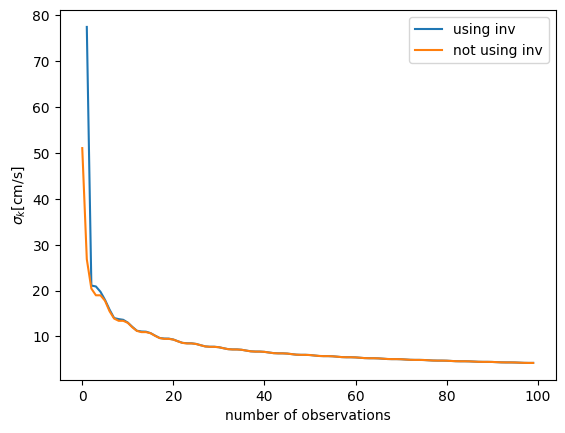

In [40]:
#plt.scatter(range(len(sigma_ks)), sigma_ks, s=5, label='using inv')
#plt.scatter(range(len(sigma_ks_stable)), sigma_ks_stable, s=5, label='not using inv')
plt.plot(range(len(sigma_ks)), sigma_ks, label='using inv')
plt.plot(range(len(sigma_ks_stable)), sigma_ks_stable, label='not using inv')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[cm/s]")
plt.legend()
plt.savefig('obs-vs-sigma_k.pdf', format='pdf')
plt.plot()
plt.show()

#### Side worry: sometimes, my FIMs are singular and can't be inverted. 

Upon inspection, it looks like the determinants are sometimes (rarely, but sometimes) zero, especially when there are very (too?) few observations. Upon further inspection, it looks like the matrix terms that go into calculating the determinants are often really small - like, smaller than machine epsilon small. What to do about it? Just ignore it? Uniformly add a scalar value to all matrix terms? 

I'm going to try a few things. 

First, let's just make a fiducial FIM and run det(fim). Then, let's run symbolic det on it. Then, let's manually compute det(fim). 

In [11]:
test_t = np.linspace(2340, 2400, 111) # 2340 to 2450, vs 2340 to 2400, for 111 obs
dets = []
sigma_ks_squared = []

# create time series and appropriately sized covariance matrix
test_t_temp = test_t[:2]
print(test_t_temp)
test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s

# calculate FIM
fim = calculate_fim(test_t_temp, test_sigma, test_theta)

print(fim) 
print(det(fim))
print(inv(fim))

"""
for i in range(len(test_t)-3):
    # create time series and appropriately sized covariance matrix
    test_t_temp = test_t[:i+4]
    test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s
    
    # calculate FIM
    fim = calculate_fim(test_t_temp, test_sigma, test_theta)
    dfadfdsf
"""

[2340.         2340.54545455]
[[ 1.25476883e-04 -2.14936766e-01 -1.10481515e-01]
 [-2.14936766e-01  8.06826970e+02  4.08574857e+02]
 [-1.10481515e-01  4.08574857e+02  2.06940470e+02]]
0.0


/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


LinAlgError: Singular matrix

^This is how I first noitced this problem. det(fim) is 0, and so inv(fim) errors out. 

EDIT: Upon even further inspection, it looks like sometimes just changing the time bound (while holding n_obs constant) will change an FIM from invertible to degenerate. For example, going from 2340-2450, to 2340-2400 BJD for 111 observations makes the FIM singular. Similarly, changing the number of observations for the same time support can make or break the matrix. Holding t at 2340-2400, going from 61 to 60 observations corrects the degeneracy of the matrix. (see below)

What if I manually calculated the determinant?

In [ ]:
1.25476883e-04*(8.06826970e+02*2.06940470e+02 - 4.08574857e+02*4.08574857e+02)

In [ ]:
 -2.14936766e-01 * (-2.14936766e-01 *2.06940470e+02 - -1.10481515e-01*4.08574857e+02)

In [ ]:
-1.10481515e-01*(-2.14936766e-01*4.08574857e+02 - 8.06826970e+02*-1.10481515e-01)

In [12]:
0.00398246159073211 - -0.14204178199869455 + -0.14602425317019033

-9.58076365464855e-09

In [13]:
det(fim)

0.0

In [14]:
import sympy as sp
from sympy import *
from sympy.matrices import Matrix

In [15]:
M = sp.Matrix(fim)

In [16]:
M.det()

1.77635683940025e-15

Why do these three methods mismatch??

Scarier scenario: even for the well-behaved FIMs, do manual, linalg, and sympy all disagree as well? Only one way to find out.

In [17]:
from numpy.linalg import inv, det

test_t = np.linspace(2340, 2400, 61) # 2340 to 2450, vs 2340 to 2400, for 111 obs
dets = []
sigma_ks_squared = []

# create time series and appropriately sized covariance matrix
test_t_temp = test_t[:2]
print(test_t_temp)
test_sigma = np.diag(np.ones(len(test_t_temp))*30) # cm/s

# calculate FIM
fim = calculate_fim(test_t_temp, test_sigma, test_theta)

print(fim) 
print(det(fim))
print(inv(fim))

[2340. 2341.]
[[ 3.83879448e-04 -3.15382284e-01 -1.65990676e-01]
 [-3.15382284e-01  6.97756431e+02  3.55696830e+02]
 [-1.65990676e-01  3.55696830e+02  1.81437159e+02]]
-4.547091327363591e-15
[[-1.73099608e+16  4.00319967e+14 -8.00639934e+14]
 [ 4.00319967e+14 -9.25802651e+12  1.85160530e+13]
 [-8.00639934e+14  1.85160530e+13 -3.70321060e+13]]


/tmp/ipykernel_3002366/564434563.py:60: RuntimeWarning: divide by zero encountered in true_divide
  factor2 = 1/sigma**2


In [18]:
-3.15382284e-01*1.81437159e+02 - -1.65990676e-01*3.55696830e+02

1.820291654865919

In [19]:
-3.15382284e-01*1.81437159e+02

-57.22206560789116

In [20]:
-1.65990676e-01*3.55696830e+02

-59.04235726275708

In [21]:
3.83879448e-04*(6.97756431e+02*1.81437159e+02 - 3.55696830e+02*3.55696830e+02)

0.030215014142300333

In [22]:
-3.15382284e-01*(-3.15382284e-01*1.81437159e+02 - -1.65990676e-01*3.55696830e+02)

-0.5740877396577533

In [23]:
-1.65990676e-01*(-3.15382284e-01*3.55696830e+02 - 6.97756431e+02 * -1.65990676e-01)

-0.6043028345449212

In [24]:
0.030215014142300333 - -0.5740877396577533 + -0.6043028345449212

-8.074486756992627e-08

In [25]:
M = sp.Matrix(fim)
M.det()

-3.55271367880050e-15

Aaaand, wolfram says -8e-8 (https://www.wolframalpha.com/input?i2d=true&i=%7B%7B3.83879448e-04%2C-3.15382284e-01%2C-1.65990676e-01%7D%2C%7B-3.15382284e-01%2C6.97756431e%2B02%2C3.55696830e%2B02%7D%2C%7B-1.65990676e-01%2C3.55696830e%2B02%2C1.81437159e%2B02%7D%7D). So sympy and linalg agree-ish (at least they're same order of magnitude), but they heavily disagree with manual and wolfram, which agree with each other.

I don't like this at all...

In [26]:
import scipy
scipy.linalg.det(fim)

-4.547091327363593e-15

At least scipy and numpy agree (I needed a small win). 

#### Let's try bumping all elements up by a scalar factor to get everyone comfortably larger than machine epsilon.

inv(kA) = inv(A)/k, so it should be safe to do this...?

In [17]:
fim*1e4

array([[ 3.83879448e+00, -3.15382284e+03, -1.65990676e+03],
       [-3.15382284e+03,  6.97756431e+06,  3.55696830e+06],
       [-1.65990676e+03,  3.55696830e+06,  1.81437159e+06]])

In [61]:
from numpy.linalg import inv, det

det(fim*1e4)

-0.0002483318143584188

In [25]:
det(fim)*1e4

-4.5470913273635905e-11

Wew. That's not supposed to happen, right?

In [22]:
3.83879448e+00*(6.97756431e+06*1.81437159e+06 - 3.55696830e+06*3.55696830e+06)

30215014142.29632

In [23]:
-3.15382284e+03*(-3.15382284e+03*1.81437159e+06 - -1.65990676e+03*3.55696830e+06)

-574087739657.7544

In [24]:
-1.65990676e+03*(-3.15382284e+03*3.55696830e+06 - -1.65990676e+03*6.97756431e+06)

-604302834544.921

In [26]:
30215014142.29632 - -574087739657.7544 + -604302834544.921

-80744.87036132812

In [49]:
import sympy as sp

print(sp.Matrix(fim*1e4).det())
print(sp.Matrix(fim*1e4).det()/1e4)

0.0117187500000000
1.17187500000000e-6


In [63]:
print(det(fim*1e5))
print(det(fim)*1e5)

-12.317257992177334
-4.5470913273635904e-10


Once again, Wolfram Alpha corroborates my manual determinant calculation and is much different from the np.linalg.det result: https://www.wolframalpha.com/input?i2d=true&i=%7B%7B3.83879448e-04%2C-3.15382284e-01%2C-1.65990676e-01%7D%2C%7B-3.15382284e-01%2C6.97756431e%2B02%2C3.55696830e%2B02%7D%2C%7B-1.65990676e-01%2C3.55696830e%2B02%2C1.81437159e%2B02%7D%7D

Furthermore, the manual/Wolfram determinant for the FIM scaled up by 1e4 has a determinant that's exactly 1e12 times bigger (from log -8 to log 4). When I scale the FIM up by 1e5, its determinant is then 8e7. So, with every scale by an order of magnitude, my determinant scales by three orders of magnitude (probably because it's a 3x3 matrix). 

And this time, np.linalg.det and sympy.Matrix(fim).det() disagree. 



Here's something from the Internet that can help: https://github.com/numpy/numpy/issues/6890

In [59]:
det(fim/np.amax(fim, axis=0, keepdims=True))

-6.336521960140912e-17

...

I need to reorient myself. Here's a base case.

In [67]:
import sympy as sp

a = np.array([[1, 2], [3,4]])
print(det(a))
print(sp.Matrix(a).det())
print(det(a*1e2))
print(det(a)*1e4)

-2.0000000000000004
-2
-19999.99999999998
-20000.000000000004


In [27]:
fim

array([[ 3.83879448e-04, -3.15382284e-01, -1.65990676e-01],
       [-3.15382284e-01,  6.97756431e+02,  3.55696830e+02],
       [-1.65990676e-01,  3.55696830e+02,  1.81437159e+02]])

In [33]:
type(fim[0][0])

numpy.float64

In [29]:
inv(fim)

array([[-1.73099608e+16,  4.00319967e+14, -8.00639934e+14],
       [ 4.00319967e+14, -9.25802651e+12,  1.85160530e+13],
       [-8.00639934e+14,  1.85160530e+13, -3.70321060e+13]])

In [30]:
scipy.linalg.inv(fim)

array([[-1.73099608e+16,  4.00319967e+14, -8.00639934e+14],
       [ 4.00319967e+14, -9.25802651e+12,  1.85160530e+13],
       [-8.00639934e+14,  1.85160530e+13, -3.70321060e+13]])

#### Other manual determinant calculations and scratch work for which I put too much time copy-pasting, so sunk-cost fallacy is making me not delete them..."yet"

In [20]:
3.99935942e-34*( 6.57973627e+02 * 4.38649084e+02 - 2.19324542e+02 * 2.19324542e+02) 

9.619110263099567e-29

In [21]:
-5.12978852e-16 * (-5.12978852e-16 *  4.38649084e+02 - -1.70992951e-16 * 2.19324542e+02)

9.619110266435248e-29

In [22]:
-1.70992951e-16 * (-5.12978852e-16 * 2.19324542e+02 - -1.70992951e-16*6.57973627e+02) 

-6.674154045664273e-38

In [23]:
9.619110263099567e-29 - 9.619110266435248e-29 + -6.674154045664273e-38

-1.0009835178189898e-37

In [15]:
1.05275780e+04*9.86960440e+02 - 1.97392088e+03*1.97392088e+03

6493939.374514345

In [14]:
1.97392088e+03*1.97392088e+03

3896363.640499974

In [13]:
1.05275780e+04*9.86960440e+02

10390303.015014319

In [9]:
6.39897507e-33 * (1.05275780e+04*9.86960440e+02 - 1.97392088e+03*1.97392088e+03)

4.155455616360869e-26

In [10]:
-8.20766163e-15 * (-8.20766163e-15*9.86960440e+02 - 1.53893655e-15*(-1.97392088e+03))

4.155455648018569e-26

In [11]:
1.53893655e-15 * (-8.20766163e-15*-1.97392088e+03 - 1.05275780e+04*1.53893655e-15)

1.5428752258607994e-34

In [12]:
4.155455616360869e-26 - 4.155455648018569e-26 + 1.5428752258607994e-34

-1.6228947576755225e-34